<center><img src="/images/gin/thumbnail.png"></center>

::: {.column-margin}
Find a lot more architectures and applications using graph neural networks in my book, [**Hands-On Graph Neural Networks**](https://mlabonne.github.io/blog/book.html) 👇
<a href="https://packt.link/a/9781804617526"><img src="/images/gnnbook/cover.png" alt="Hands-On Graph Neural Networks Using Python" id="gnn-book"></a>
:::

Graph Neural Networks are not limited to classifying nodes.

One of the most popular applications is **graph classification**. This is a common task when dealing with molecules: they are represented as graphs and features about each atom (node) can be used to predict the behavior of the entire molecule.

However, GNNs only learn node embeddings. How to combine them in order to produce an entire **graph embedding**? In this article, we will:

* See a new type of layer, called "**global pooling**", to combine node embeddings;

* Introduce a new architecture called **Graph Isomorphism Network** (GIN), designed by [Xu et al.](https://arxiv.org/abs/1810.00826v3) in 2018.

We'll detail the advantages of GIN in terms of **discriminative power** compared to a GCN or GraphSAGE, and its connection to the Weisfeiler-Lehman test. Beyond its powerful aggregator, GIN brings exciting takeaways about GNNs in general.

You can run the code with the following [Google Colab notebook](https://colab.research.google.com/drive/1b6SWugNKnxsI0L9auX1zwszlXf3rRZyS?usp=sharing).

In [10]:
# Install PyTorch Geometric
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

## 🌐 I. PROTEINS dataset

<center><img src="/images/gin/proteinimager.png">
<i>3D plot of a protein by DeepMind.</i></center></br>

[PROTEINS](https://chrsmrrs.github.io/datasets/docs/datasets/) is a popular dataset in bioinformatics. It is a collection of **1113 graphs** representing proteins, where nodes are amino acids. Two nodes are connected by an edge when they are close enough (< 0.6 nanometers). The goal is to classify each protein as an **enzyme** or **not**.

Enzymes are a particular type of **proteins** that act as catalysts to speed up chemical reactions in the cell. They are essential for digestion (e.g., lipases), respiration (e.g., oxidases), and other crucial functions of the human body. They are also used in commercial applications, like the production of antibiotics.

This dataset is also available on TUDataset and implemented in PyTorch Geometric.

In [11]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 117
Number of features: 3
Number of classes: 2


I'm not a biochemist so I'm curious about these proteins. Let's plot one as a graph to see what it looks like.

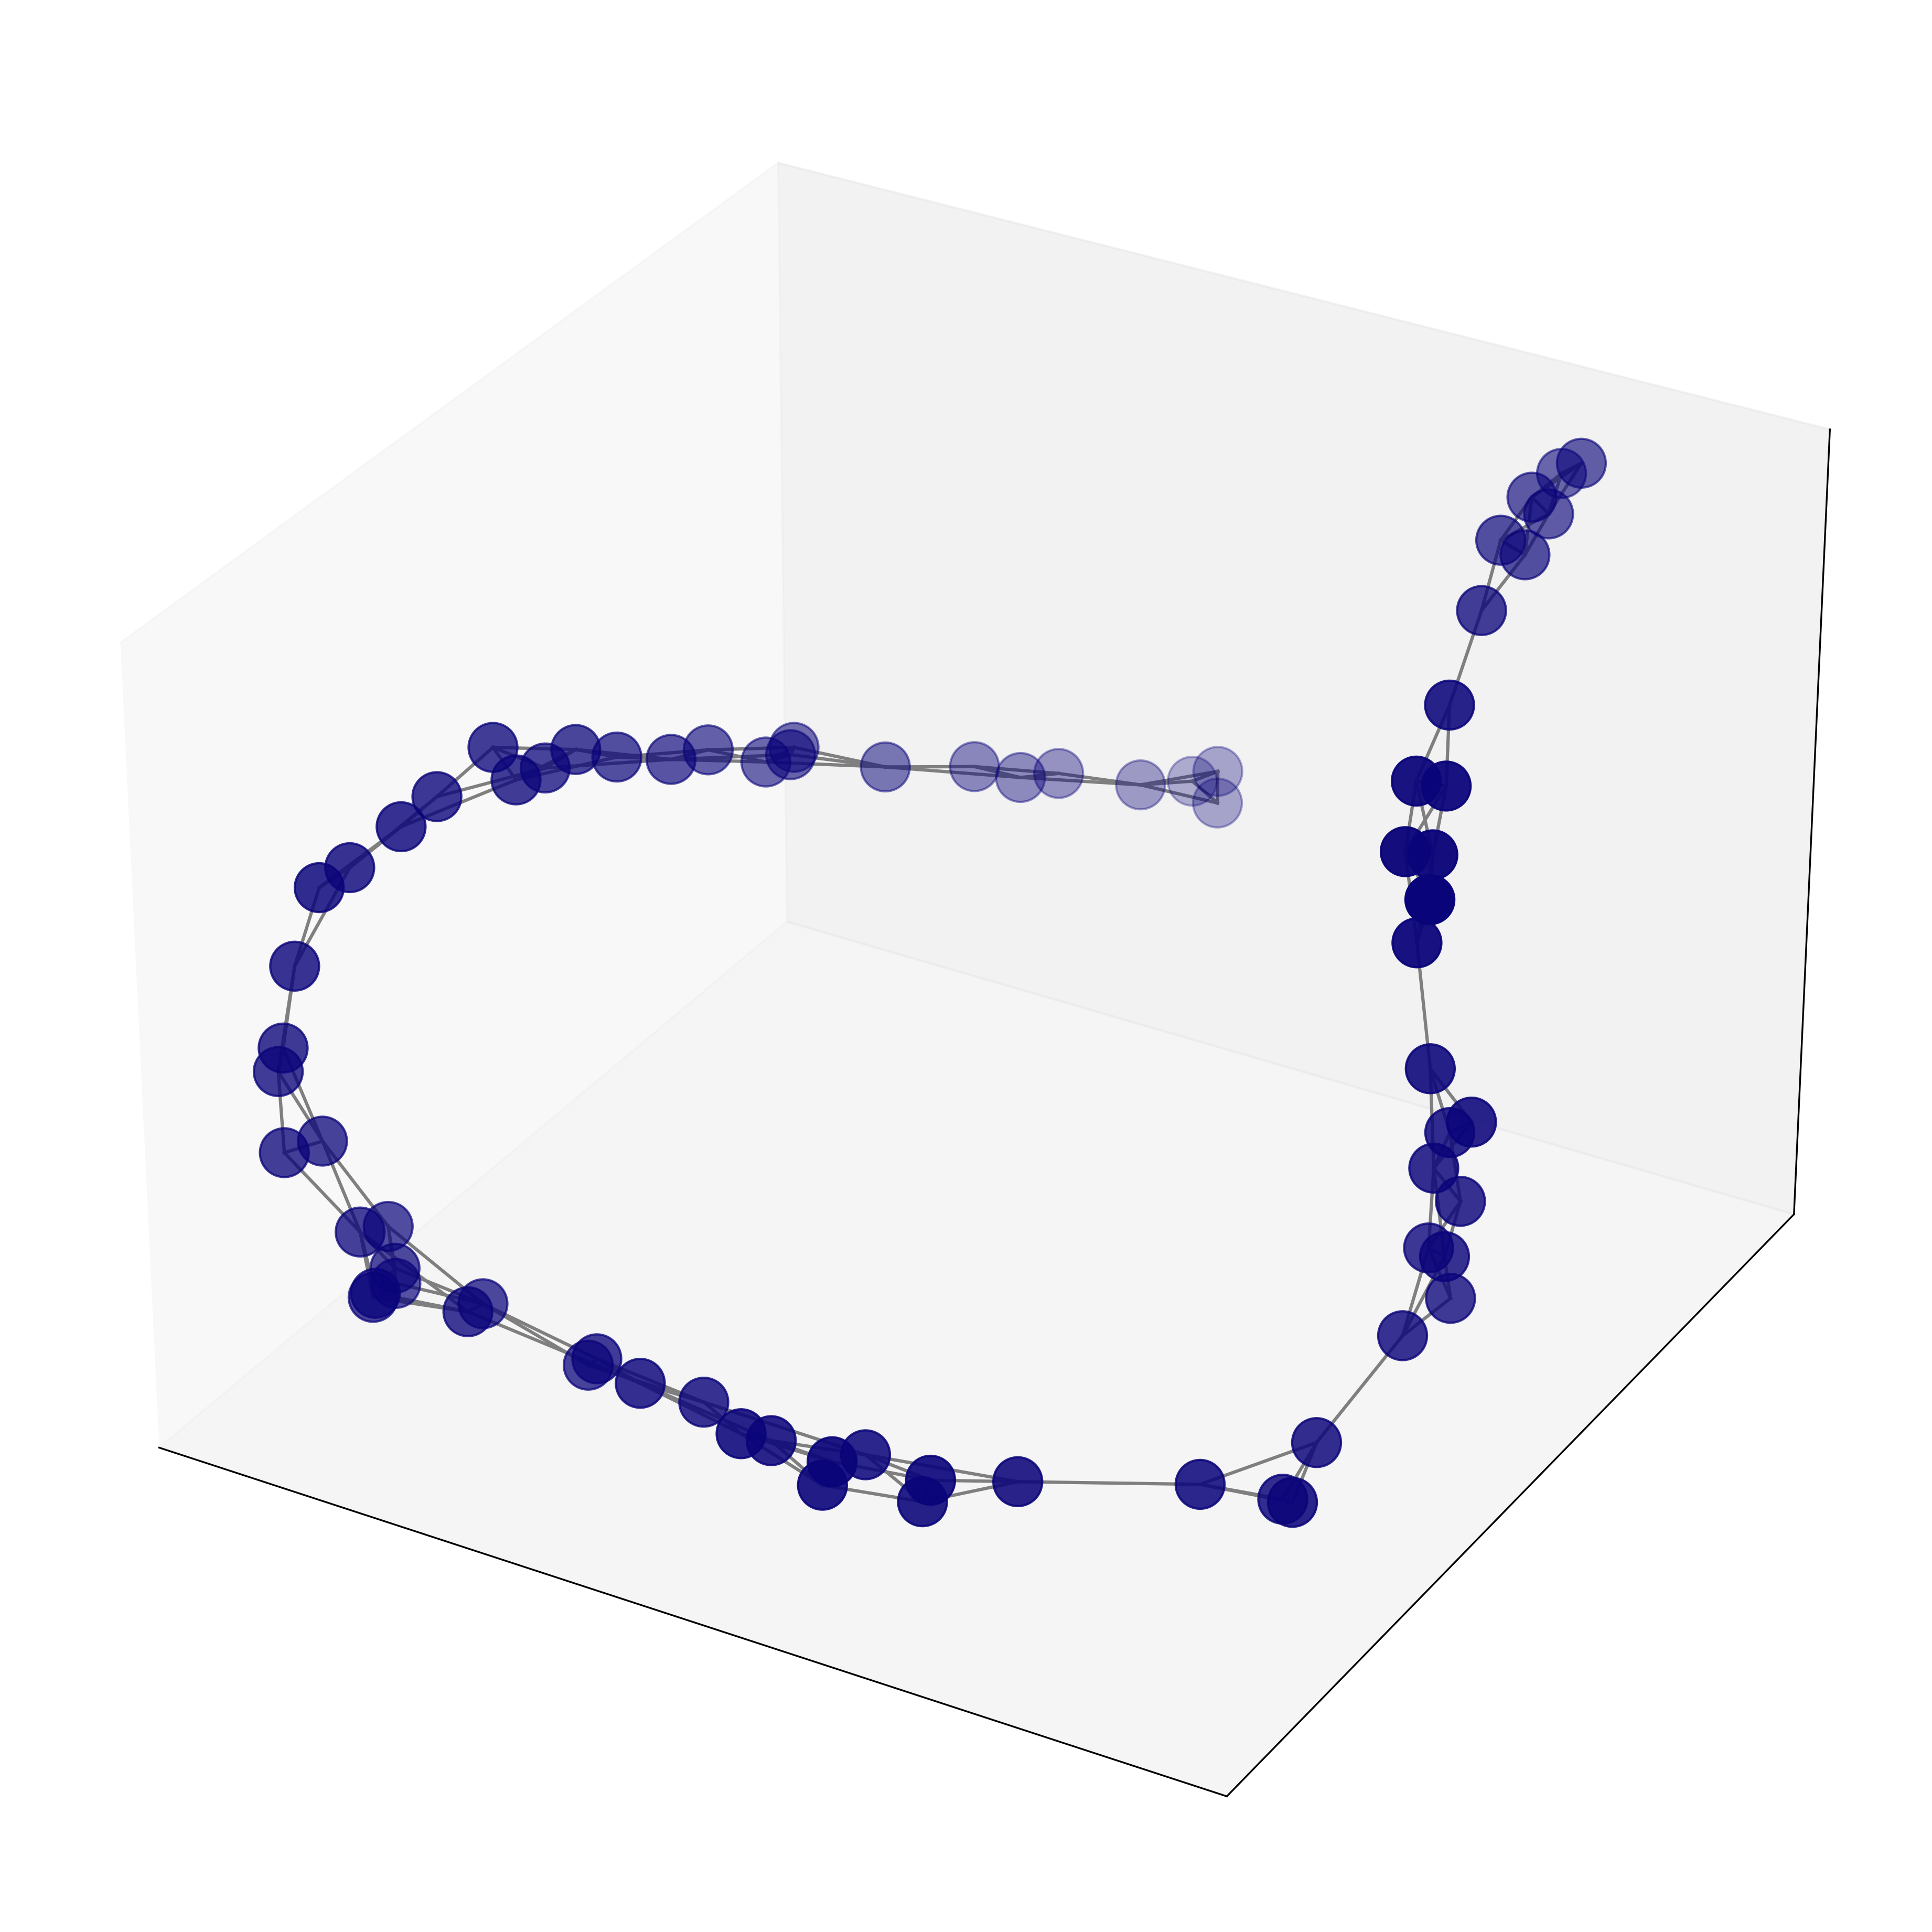

In [12]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[2], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

The previous 3D structure is **randomly generated**: obtaining the correct 3D representation is a problem so difficult it's the whole point of [AlphaFold](https://alphafold.ebi.ac.uk/).

Graphs are not the only way to represent molecules. The [simplified molecular-input line-entry system (**SMILES**)](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) is another popular method, which uses a line (string) notation. It is obtained by printing the nodes encountered in a depth-first tree traversal of a slightly modified molecular graph.

Researchers often use this representation when working with molecules or chemical compounds. Fortunately for us, the PROTEINS dataset is **already encoded** in the form of graphs. Otherwise, we could have to translate the SMILES strings into `networkx` graphs.

It doesn't mean we'll directly feed the PROTEINS dataset to our GNN. If [GraphSAGE](https://mlabonne.github.io/blog/graphsage/) taught us anything, it's that **mini-batching is incredibly efficient**. It is now an indispensable tool whenever we implement a GNN.

In [13]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 7966], x=[2114, 3], y=[64], batch=[2114], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 8492], x=[2263, 3], y=[64], batch=[2263], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 9518], x=[2589, 3], y=[64], batch=[2589], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 10846], x=[3008, 3], y=[64], batch=[3008], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 9618], x=[2586, 3], y=[64], batch=[2586], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 7572], x=[2027, 3], y=[64], batch=[2027], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 10512], x=[2875, 3], y=[64], batch=[2875], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 7034], x=[1855, 3], y=[64], batch=[1855], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 11966], x=[3313, 3], y=[64], batch=[3313], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 9898], x=[2764, 3], y=[64], ba

PROTEINS is not a huge dataset, but mini-batching will speed up the training nonetheless. We could use a GCN or a GAT, but there's a new architecture I'd like to introduce: the **Graph Isomorphism Network**.

## 🍾 II. Graph Isomorphism Network (GIN)

GIN was designed by researchers trying to maximize the **representational (or discriminative) power** of a GNN. But how do you define a "representational power"?

### A. Weisfeiler-Lehman test

A way to characterize the "power" of a GNN is to use the Weisfeiler-Lehman (WL) graph isomorphism test. [Isomorphic graphs](https://en.wikipedia.org/wiki/Graph_isomorphism) mean that they have the **same structure**: identical connections but a permutation of nodes. The WL test is able to tell if two graphs are non-isomorphic, but it cannot guarantee that they are isomorphic.

<center><img src="/images/gin/isomorphic_graphs.png">
<i>Two isomorphic graphs.</i></center></br>

This might not seem like much, but it can be **extremely difficult** to tell two large graphs apart. In fact, this problem is not known to be solvable in polynomial time, nor to be NP-complete. It might even be somewhere in between, in the computational complexity class [NP-intermediate](https://en.wikipedia.org/wiki/Graph_isomorphism_problem) (if it only exists).

Okay, but how is it **related** to GNNs? Some researchers in graph learning noticed that **this test and the way GNNs learn are oddly similar**. In the WL test,

1. Every node starts with the **same label**;
2. Labels from neighboring nodes are aggregated and **hashed** to produce a new label;
3. The previous step is repeated until the labels **stop changing**.

If you're interested in the WL test, I would recommend [this blog post](https://davidbieber.com/post/2019-05-10-weisfeiler-lehman-isomorphism-test/) by David Bieber and [this article](https://towardsdatascience.com/expressive-power-of-graph-neural-networks-and-the-weisefeiler-lehman-test-b883db3c7c49) by Michael Bronstein.

Not only this test is similar to how feature vectors are aggregated in GNNs, but its ability to tell graphs apart makes it **more powerful** than a lot of architectures, including GCNs and GraphSAGE. This is what inspired [Xu et al.](https://arxiv.org/abs/1810.00826v3) to design a new aggregator that is proven to be as good as the WL test.

### B. One aggregator to rule them all

To be as good as the WL test, this new aggregator must produce **different node embeddings** when dealing with non-isomorphic graphs.

We'll skip the math-heavy part of the paper, but the solution they found is to use two injective functions. Which ones? We don't know, we can just learn them with a MLP!

* With GATs, we used a neural network to learn the **best weighting factors** for a given task;
* With GINs, we now learn the **approximation of two injective functions** thanks to the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

Here's how to calculate the **hidden vector** of a particular node $i$ with GIN:

$$h_i = MLP\bigg((1+ɛ) \cdot x_i + \sum_{j \in \mathcal{N}_i}x_j\bigg)$$

In this formula, $ɛ$ determines the **importance of the target node** compared to its neighbors (it has the same importance if $ɛ = 0$). It can be a learnable parameter or a fixed scalar.

Note that we talk about MLPs to highlight the fact there is more than one layer. According to the authors, one layer is **not sufficient** for graph learning in general.

### C. Global pooling

Global pooling or graph-level readout consists of producing a **graph embedding** using the node embeddings calculated by the GNN.

A simple way to obtain a graph embedding $h_G$ is to use the **mean**, **sum**, or **max** of every node embedding $h_i$:

$$\text{Mean}: h_G = \frac{1}{N} \sum_{i=0}^N h_i \\
\text{Sum}: h_G = \sum_{i=0}^N h_i \\
\text{Max}: h_G = {max}_{i=0}^N(h_i)$$

The authors make two important points about graph-level readout:

* To consider all structural information, it is necessary to **keep embeddings from previous layers**;
* The sum operator is surprisingly **more expressive** than the mean and the max.

These observations lead them to propose the following global pooling method:

$$h_G = \sum_{i=0}^N{h_i^0}\ || \ \dots \ || \ \sum_{i=0}^N{h_i^k}$$

For each layer, embeddings nodes are **summed** and the result is **concatenated**. This solution combines the expressiveness of the sum operator with the memory of previous iterations from the concatenation.

## 🧠 III. GIN in PyTorch Geometric

It is always interesting to see the differences between the original design and its implementations.

There is a [`GINConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) layer in PyTorch Geometric with different parameters:

* `nn`: the **MLP** that is used to approximate our two injective functions;
* `eps`: the initial value of $ɛ$, which is **0 by default**;
* `train_eps`: a True/False statement to determine if $ɛ$ is trainable, which is **False by default**.

You can see that $ɛ$ is entirely removed by default in this implementation: it's a hyperparameter we can tune, but probably not an essential one.

There is a **second GIN layer** in PyTorch Geometric, called `GINEConv`. It comes from [this paper's implementation](https://arxiv.org/pdf/1905.12265.pdf) of GIN, which applies a $ReLU$ function to the neighbors' features. We won't use it in this tutorial, since the benefits are not clear.

We still need to design a MLP for the `GINConv` layer. Here's the design we'll implement, inspired by the original paper:

<center><img src="/images/gin/mlp.png" width=800></center>

The paper stacks **5 layers** but we'll be more humble with **3 layers** instead. Here is what the entire architecture looks like:

<center><img src="/images/gin/architecture.png"></center>

I could not find any implementation of GIN with graph embedding **concatenation**, so here is my version (it improves the accuracy by 1% on average). Let's compare it to a GCN with a simple mean pooling (and no concatenation).

In [14]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return hG, F.log_softmax(h, dim=1)

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h, F.log_softmax(h, dim=1)

gcn = GCN(dim_h=32)
gin = GIN(dim_h=32)

In [15]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.01,
                                      weight_decay=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
          optimizer.zero_grad()
          _, out = model(data.x, data.edge_index, data.batch)
          loss = criterion(out, data.y)
          total_loss += loss / len(loader)
          acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
          loss.backward()
          optimizer.step()

          # Validation
          val_loss, val_acc = test(model, val_loader)

    # Print metrics every 10 epochs
    if(epoch % 10 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
              f'| Train Acc: {acc*100:>5.2f}% '
              f'| Val Loss: {val_loss:.2f} '
              f'| Val Acc: {val_acc*100:.2f}%')
          
    test_loss, test_acc = test(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
    
    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        _, out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gcn = train(gcn, train_loader)
gin = train(gin, train_loader)

Epoch 100 | Train Loss: 0.67 | Train Acc: 60.61% | Val Loss: 0.70 | Val Acc: 54.50%
Test Loss: 0.69 | Test Acc: 55.99%
Epoch 100 | Train Loss: 0.49 | Train Acc: 75.61% | Val Loss: 0.53 | Val Acc: 78.99%
Test Loss: 0.60 | Test Acc: 66.93%


This time, there's no competition!

The GIN architecture completely outperforms the GCN. This gap (10% accuracy on average) is due to several reasons:

* GIN's aggregator is specifically designed to **discriminate graphs** that the GCN's aggregator cannot;
* Graph hidden vectors from every layer are **concatenated instead** of only considering the last one;
* The sum operator is **superior** to the mean operator (at least in theory).

Let's visualize the proteins we classified with the GCN and the GIN.

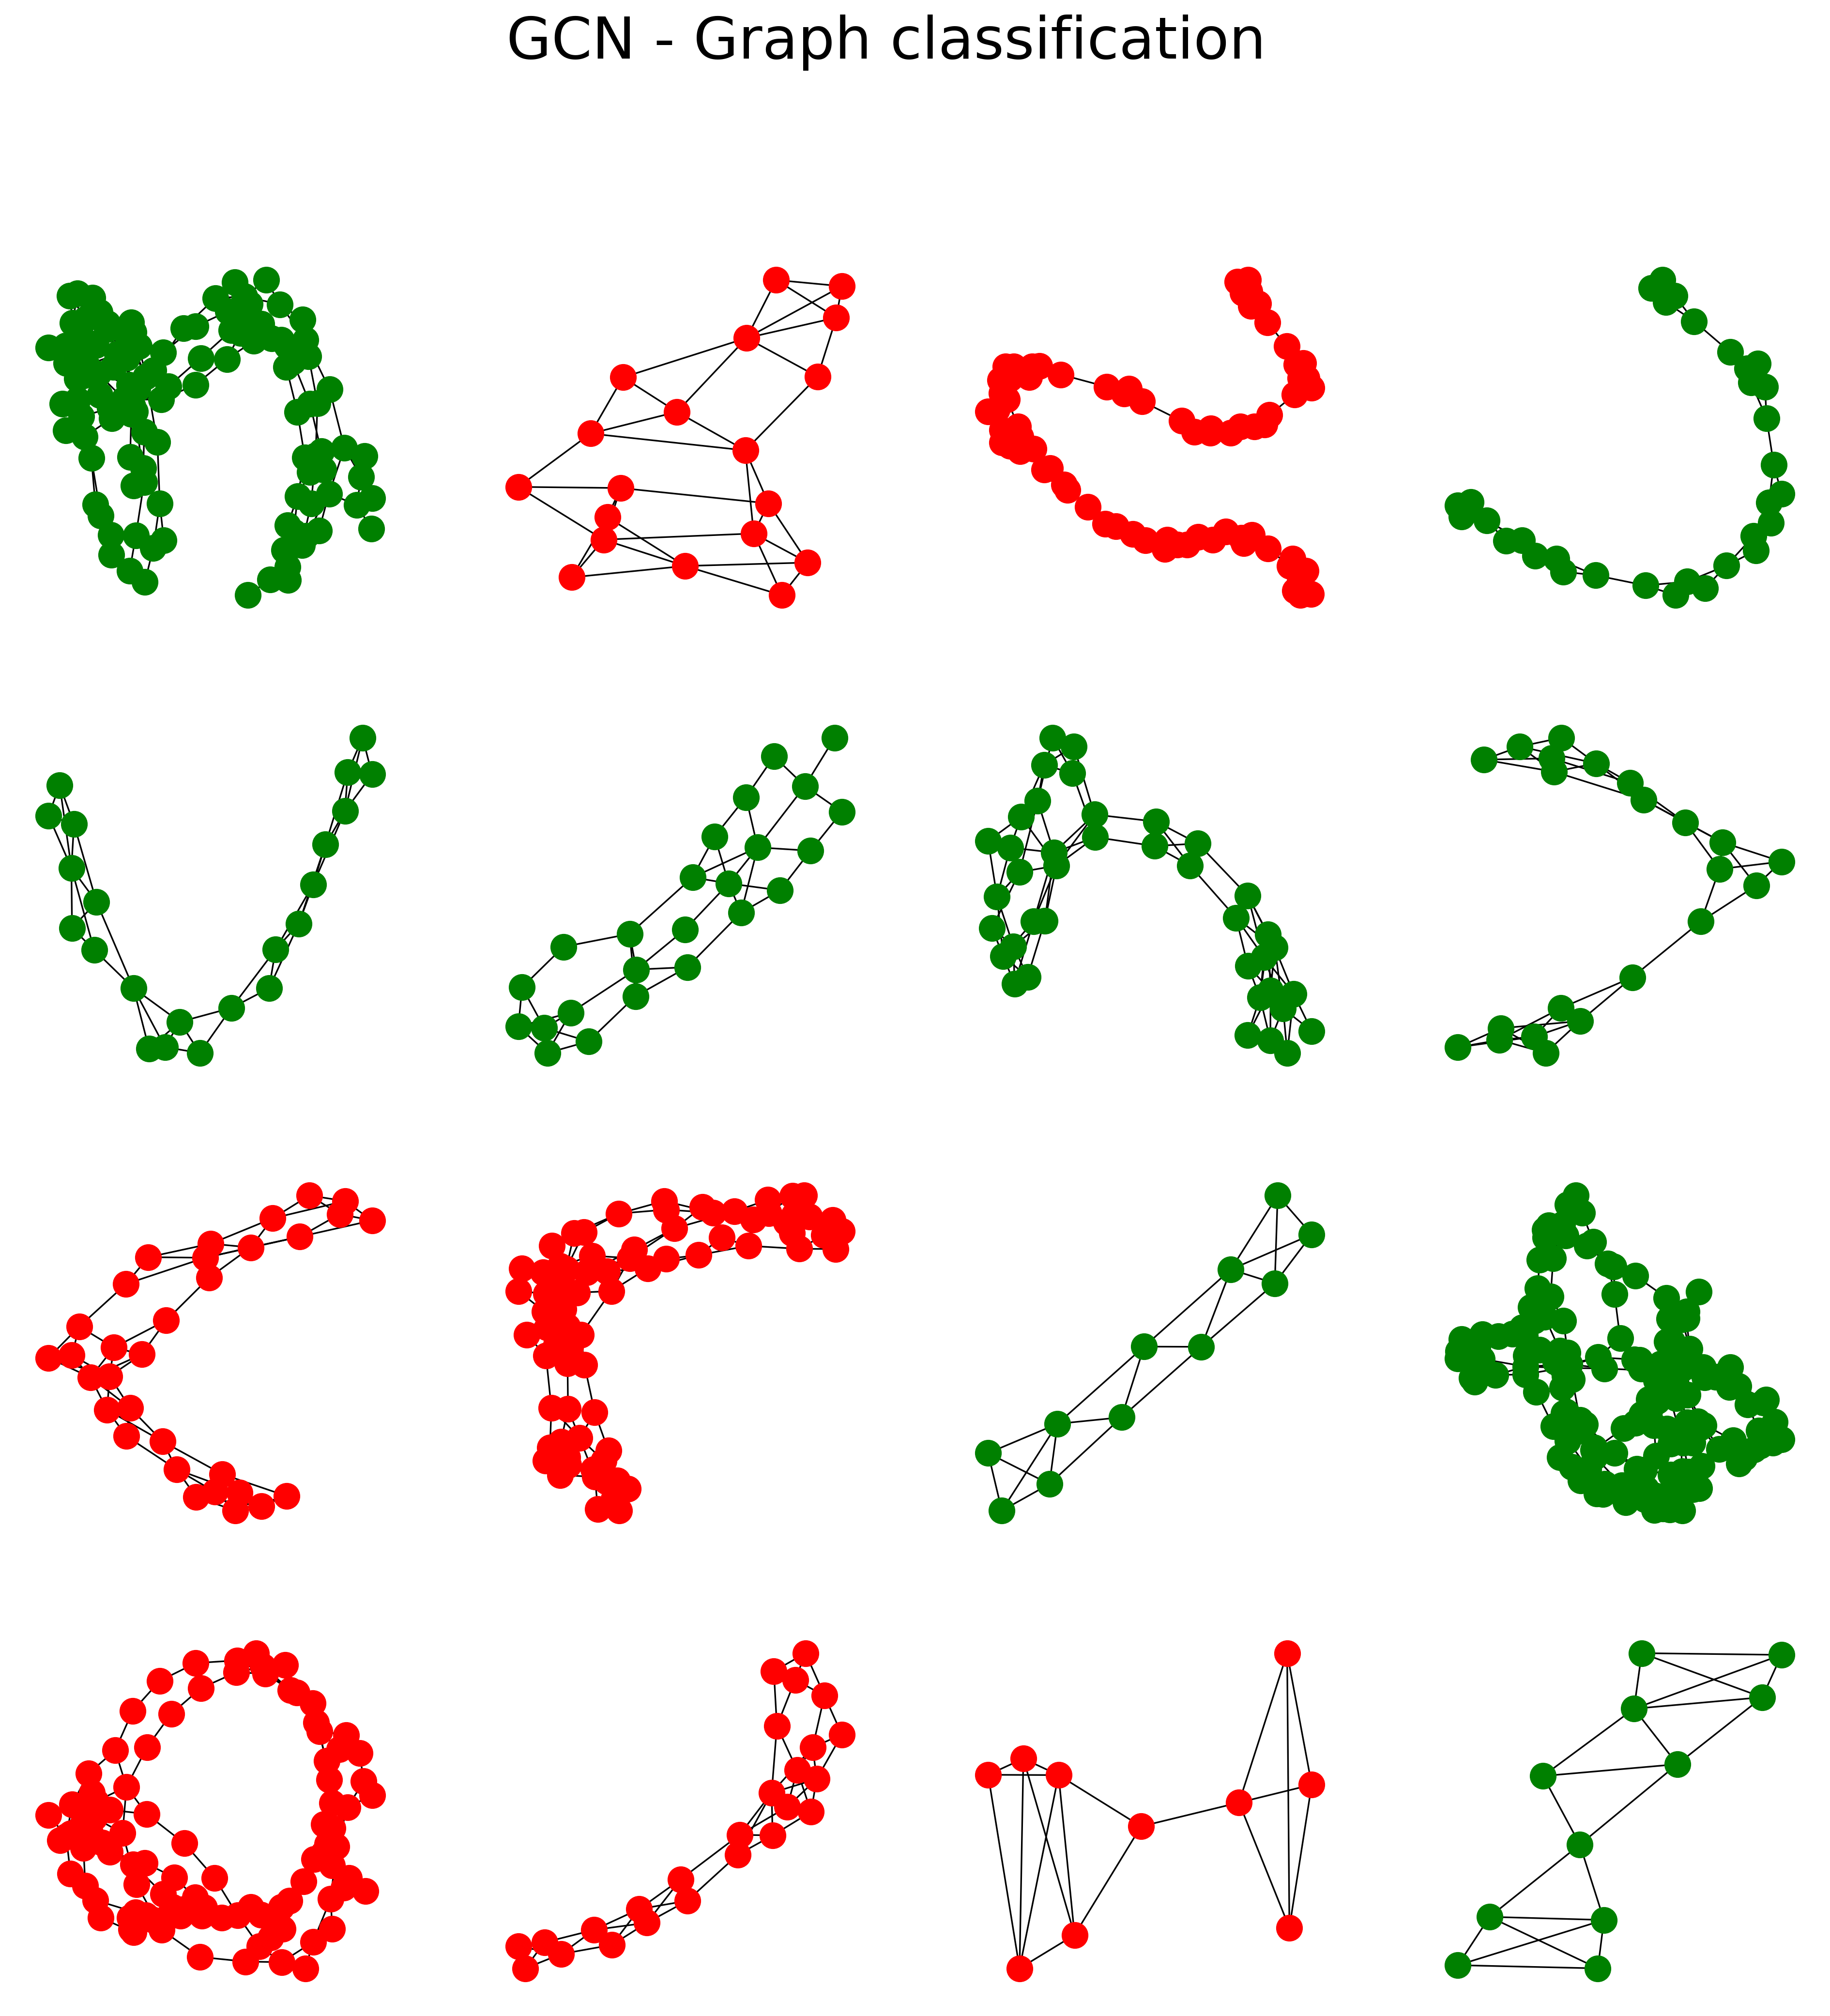

In [16]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

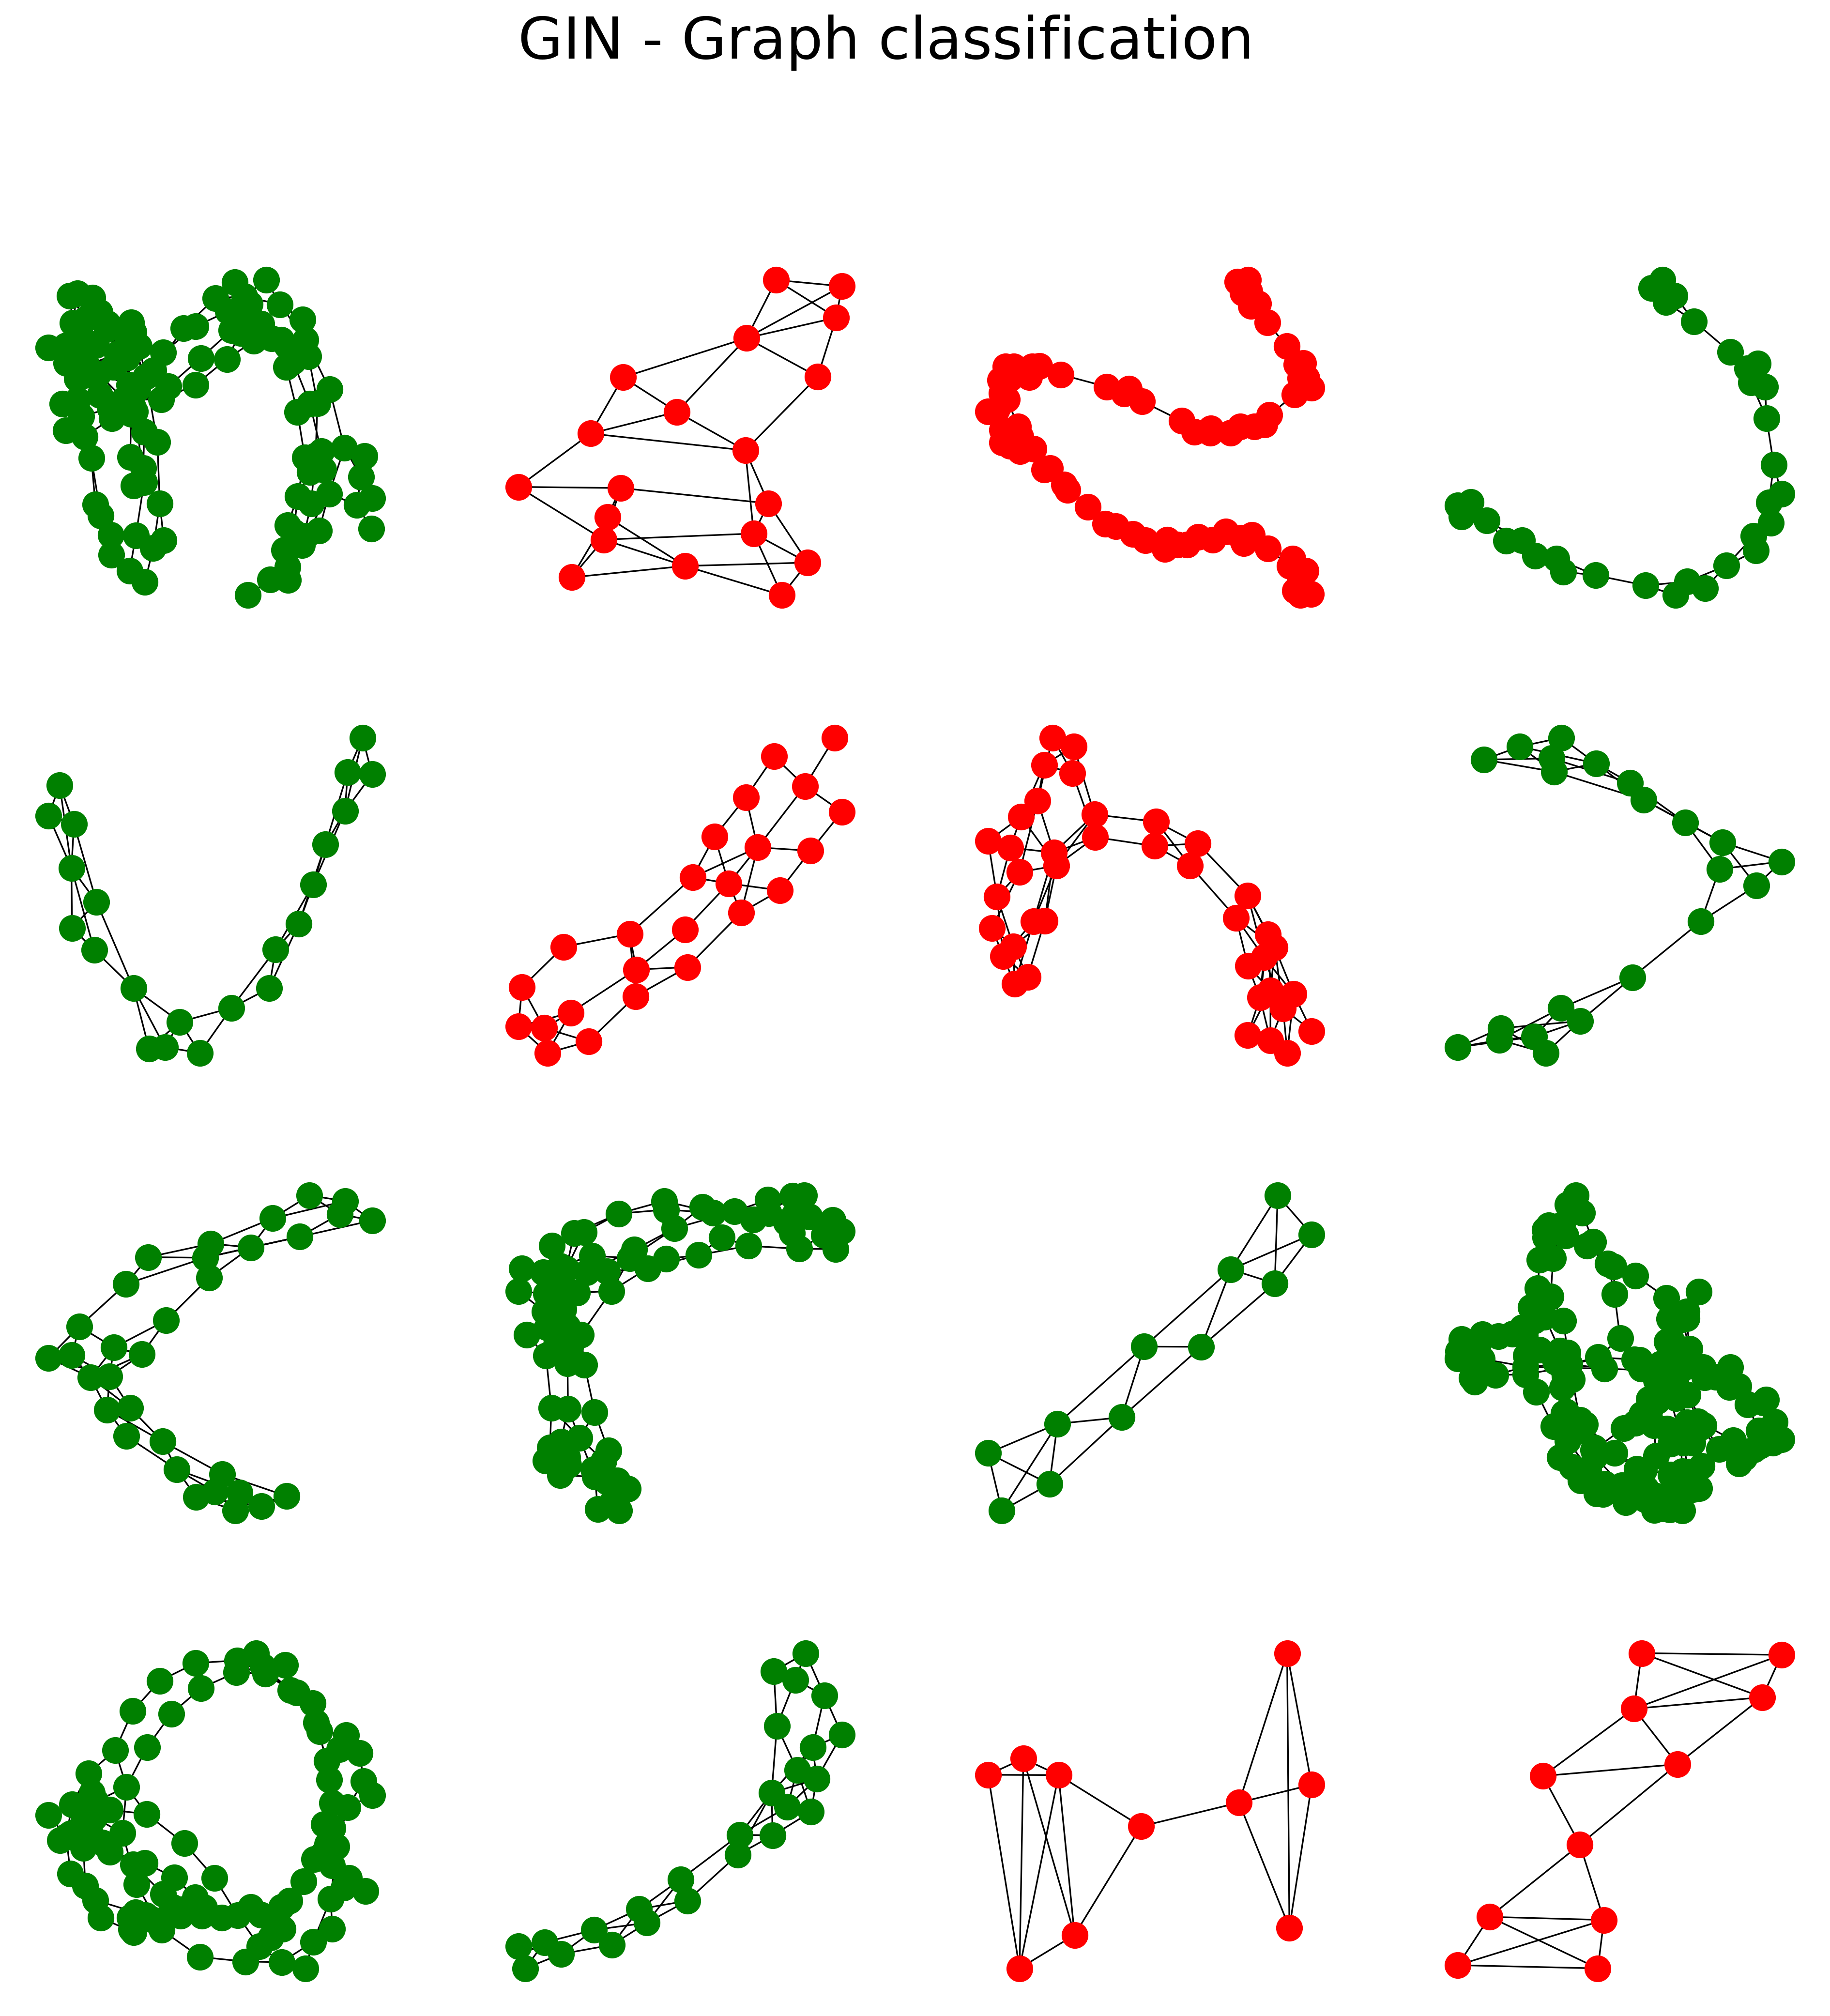

In [17]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

Interestingly enough, the two models make **different mistakes**. This is a common result in machine learning when different algorithms are applied to the same problem.

We can take advantage of this behavior by creating an **ensemble**. There are many ways of combining our graph embeddings. The simplest method is to take the mean of the normalized output vectors.

In [18]:
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc = 0

for data in test_loader:
    # Get classifications
    _, out_gcn = gcn(data.x, data.edge_index, data.batch)
    _, out_gin = gin(data.x, data.edge_index, data.batch)
    out = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc*100:.2f}%')

GCN accuracy:     55.99%
GIN accuracy:     66.93%
GCN+GIN accuracy: 67.45%


This time, we're lucky enough to see the **accuracy improved**.

Obviously, it's not always the case. More sophisticated methods involve building an entirely different ML algorithm for classification, such as a Random Forest. This classifier takes graph embeddings as inputs and outputs the final classification.

## Conclusion

Graph Isomorphism Networks are an important step in the understanding of GNNs.

They not only improve the accuracy scores on several benchmarks but also provide a **theoretical framework** to explain why one architecture is better than another. In this article,

* We saw a new task with **graph classification**, performed with global pooling;
* We introduced the **WL test** and its connection with the new GIN layer;
* We implemented a GIN and a GCN and made an simple **ensemble** with their classifications.

Although GINs achieve good performance, especially with social graphs, their theoretical superiority **doesn't always translate well** in the real world. It is true with other ["provably powerful" architectures](https://arxiv.org/pdf/2003.00982.pdf), which tend to **underperform in practice**, such as the 3WLGNN.

If you enjoyed this article, please leave a **few claps** and [**follow me on Twitter**](https://twitter.com/maximelabonne) for more graph content! 📣

## 🌐 Graph Neural Network Course

<a href="https://github.com/mlabonne/Graph-Neural-Network-Course" class="related">🔎 Course overview</a>

<a href="https://mlabonne.github.io/blog/intrognn/" class="related">📝 Chapter 1: Introduction to Graph Neural Networks</a>

<a href="https://mlabonne.github.io/blog/gat/" class="related">📝 Chapter 2: Graph Attention Network</a>

<a href="https://mlabonne.github.io/blog/graphsage/" class="related">📝 Chapter 3: GraphSAGE</a>

<a href="https://mlabonne.github.io/blog/gin/" class="related">📝 Chapter 4: Graph Isomorphism Network</a>